# Relax Inc.
---

Import modules.

In [14]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize, scale
import matplotlib.pyplot as plt
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np
import json

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300

%matplotlib inline


Load data.

In [15]:
path = '/Users/LuisRa/Desktop/relax_challenge/'
engagement = 'takehome_user_engagement.csv'
users = 'takehome_users.csv'

dfEng = pd.read_csv(path + engagement)
dfUsers = pd.read_csv(path + users, encoding = 'latin-1')

print("\nSource:", engagement)
print("Rows:", dfEng.shape[0])
print("Cols:",dfEng.shape[1])

print("\nSource:", users)
print("Rows:", dfUsers.shape[0])
print("Cols:",dfUsers.shape[1])


Source: takehome_user_engagement.csv
Rows: 207917
Cols: 3

Source: takehome_users.csv
Rows: 12000
Cols: 10


### Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption

Sort data by user id and time stamp (asc.), assigning row numbers per user.

In [16]:
dfEng = dfEng.drop(['visited'],axis=1)
dfEng['time_stamp'] = pd.to_datetime(dfEng['time_stamp'])
dfEng = dfEng.sort_values(by=['user_id', 'time_stamp'])
dfEng['row_num'] = dfEng.groupby(['user_id']).cumcount()+1
dfEng.head(10)

,time_stamp,user_id,row_num
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,2
3,2013-12-09 03:45:04,2,3
4,2013-12-25 03:45:04,2,4
5,2013-12-31 03:45:04,2,5
6,2014-01-08 03:45:04,2,6
7,2014-02-03 03:45:04,2,7
8,2014-02-08 03:45:04,2,8
9,2014-02-09 03:45:04,2,9


Join the next login to the previous login using the user id and row num as keys. Calculate the difference between the two timestamps in terms of day.

In [17]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

q = """

SELECT 

A.*,
B.time_stamp next_time_stamp

FROM dfEng A
LEFT JOIN dfEng B ON A.user_id = B.user_id AND A.row_num + 1= B.row_num

"""

dfEngMod  = pysqldf(q)
dfEngMod['time_stamp'] = pd.to_datetime(dfEngMod['time_stamp'])
dfEngMod['next_time_stamp'] = pd.to_datetime(dfEngMod['next_time_stamp'])

dfEngMod['days_since_prior'] = (dfEngMod['next_time_stamp'] - dfEngMod['time_stamp']).dt.days
dfEngMod.head(10)

,time_stamp,user_id,row_num,next_time_stamp,days_since_prior
0,2014-04-22 03:53:30,1,1,NaT,NaN
1,2013-11-15 03:45:04,2,1,2013-11-29 03:45:04,14.0
2,2013-11-29 03:45:04,2,2,2013-12-09 03:45:04,10.0
3,2013-12-09 03:45:04,2,3,2013-12-25 03:45:04,16.0
4,2013-12-25 03:45:04,2,4,2013-12-31 03:45:04,6.0
5,2013-12-31 03:45:04,2,5,2014-01-08 03:45:04,8.0
6,2014-01-08 03:45:04,2,6,2014-02-03 03:45:04,26.0
7,2014-02-03 03:45:04,2,7,2014-02-08 03:45:04,5.0
8,2014-02-08 03:45:04,2,8,2014-02-09 03:45:04,1.0
9,2014-02-09 03:45:04,2,9,2014-02-13 03:45:04,4.0


Iterate through this modified dataframe, one user at time, storing the user id if at some point the absolute value of the difference between the previous days since prior login and the current days since prior login being observed is 7 or less. This will determine the adopted users population.

In [18]:
users = dfEngMod['user_id'].drop_duplicates().values
store = []

for uid in users:
    
    prev = 0
    df = dfEngMod[dfEngMod['user_id'] == uid]

    for index, row in df.iterrows():

        curr = row['days_since_prior']

        if np.abs(curr - prev) <= 7:
            store.append(row['user_id'])

        else:
            prev = curr
            
store = sorted(list(set(store)))

df = dfEng
df = df[['user_id']].drop_duplicates()
df["adopted"] = [1 if user in store else 0 for user in df['user_id']]
df.head(10)

,user_id,adopted
0,1,0
1,2,1
15,3,0
16,4,0
17,5,0
18,6,0
19,7,0
20,10,1
304,11,0
305,13,0


### Modeling

Prep.

In [19]:
dfUsers.columns = ['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']

dfMod = pd.merge(dfUsers, df, how = 'left', on='user_id')

dfMod = dfMod.fillna(0)
dfMod['invited_by_user_id'] = dfMod['invited_by_user_id'].astype(int)

dfMod['creation_source'] = dfMod['creation_source'].astype('category')
dfMod['creation_source_cat'] = dfMod['creation_source'].cat.codes

dfMod = dfMod.drop(['creation_time', 'name', 'email', 'creation_source', 'user_id'], axis=1)
dfMod.head(10)

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_source_cat
0,1.398139e+09,1,0,11,10803,0.0,0
1,1.396238e+09,0,0,1,316,1.0,1
2,1.363735e+09,0,0,94,1525,0.0,1
3,1.369210e+09,0,0,1,5151,0.0,0
4,1.358850e+09,0,0,193,5240,0.0,0
5,1.387424e+09,0,0,197,11241,0.0,0
6,1.356010e+09,0,1,37,0,0.0,3
7,0.000000e+00,1,1,74,0,0.0,2
8,0.000000e+00,0,0,302,0,0.0,2
9,1.401833e+09,1,1,318,4143,1.0,1


In [7]:
y = dfMod['adopted']
df = dfMod.drop(['adopted'],axis=1)

Decision Tree


Acc. Train: 0.82
Acc. Test: 0.83


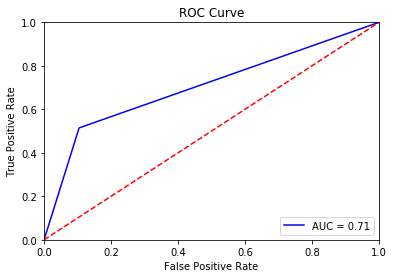


Classification Report:

               precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      2953
         1.0       0.52      0.51      0.52       647

   micro avg       0.83      0.83      0.83      3600
   macro avg       0.71      0.71      0.71      3600
weighted avg       0.83      0.83      0.83      3600


Confusion Matrix:
         pred:1  pred:0
true:1     333     314
true:0     309    2644


Feature Importance:
                       feature  importance
3  last_session_creation_time    0.671551
1                      org_id    0.177946
0          invited_by_user_id    0.094515
2         creation_source_cat    0.024773
4  enabled_for_marketing_drip    0.016479
5    opted_in_to_mailing_list    0.014735


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=89)
clf = DecisionTreeClassifier(random_state=89, class_weight='balanced')
print('\nAcc. Train:', round(np.mean(cross_val_score(clf, X_train, y_train, cv=5)),2))
clf = clf.fit(X_train, y_train)

print('Acc. Test:', round(accuracy_score(clf.predict(X_test), y_test),2))
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('\nClassification Report:\n\n', classification_report(y_test, clf.predict(X_test)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

imp = dict(zip(X_train.columns, clf.feature_importances_))
dfImp = pd.DataFrame(list(imp.items()) ,columns=['feature', 'importance'])
print('\n\nFeature Importance:\n',dfImp.sort_values(by=['importance'], ascending=False))


Random Forest


Acc. Train: 0.88
Acc. Test: 0.88


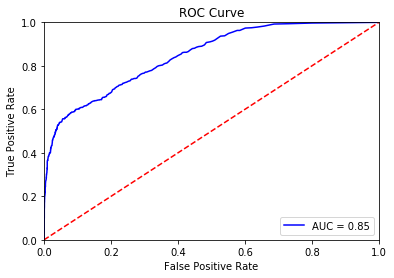


Classification Report:

               precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      2953
         1.0       0.74      0.52      0.61       647

   micro avg       0.88      0.88      0.88      3600
   macro avg       0.82      0.74      0.77      3600
weighted avg       0.87      0.88      0.87      3600


Confusion Matrix:
         pred:1  pred:0
true:1     336     311
true:0     116    2837


Feature Importance:
                       feature  importance
3  last_session_creation_time    0.649625
1                      org_id    0.198895
0          invited_by_user_id    0.106099
2         creation_source_cat    0.024888
5    opted_in_to_mailing_list    0.011040
4  enabled_for_marketing_drip    0.009452


In [9]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 89, class_weight='balanced')
print('\nAcc. Train:', round(np.mean(cross_val_score(rf, X_train, y_train, cv=5)),2))
rf.fit(X_train, y_train)

print('Acc. Test:', round(accuracy_score(rf.predict(X_test), y_test),2))
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('\nClassification Report:\n\n', classification_report(y_test, rf.predict(X_test)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

imp = dict(zip(X_train.columns, rf.feature_importances_))
dfImp = pd.DataFrame(list(imp.items()) ,columns=['feature', 'importance'])
print('\n\nFeature Importance:\n',dfImp.sort_values(by=['importance'], ascending=False))

Prep.

In [10]:
X_train_ = scale(X_train)
X_test_ = scale(X_test)

/Users/LuisRa/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
/Users/LuisRa/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/LuisRa/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app


SVM


Acc. Train: 0.5
Acc. Test: 0.49


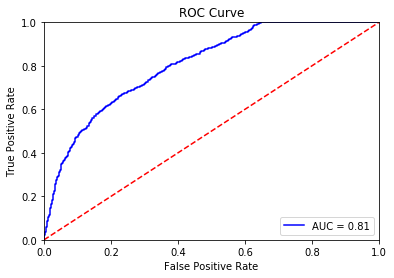


Classification Report:

               precision    recall  f1-score   support

         0.0       0.98      0.39      0.56      2953
         1.0       0.26      0.96      0.40       647

   micro avg       0.49      0.49      0.49      3600
   macro avg       0.62      0.67      0.48      3600
weighted avg       0.85      0.49      0.53      3600


Confusion Matrix:
         pred:1  pred:0
true:1     619      28
true:0    1801    1152


In [11]:
svmClf = svm.SVC(gamma='scale', probability=True, class_weight='balanced')
print('\nAcc. Train:', round(np.mean(cross_val_score(svmClf, X_train_, y_train, cv=5)),2))
svmClf.fit(X_train_, y_train)

print('Acc. Test:', round(accuracy_score(svmClf.predict(X_test_), y_test),2))
probs = svmClf.predict_proba(X_test_)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('\nClassification Report:\n\n', classification_report(y_test, svmClf.predict(X_test_)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, svmClf.predict(X_test_), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

kNN


Acc. Train: 0.8
Acc. Test: 0.77


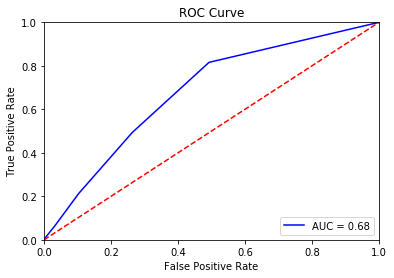


Classification Report:

               precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      2953
         1.0       0.31      0.21      0.25       647

   micro avg       0.77      0.77      0.77      3600
   macro avg       0.57      0.55      0.56      3600
weighted avg       0.74      0.77      0.76      3600


Confusion Matrix:
         pred:1  pred:0
true:1     138     509
true:0     306    2647


In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
print('\nAcc. Train:', round(np.mean(cross_val_score(knn, X_train_, y_train, cv=5)),2))
knn.fit(X_train_, y_train)

print('Acc. Test:', round(accuracy_score(knn.predict(X_test_), y_test),2))
probs = knn.predict_proba(X_test_)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('\nClassification Report:\n\n', classification_report(y_test, knn.predict(X_test_)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, knn.predict(X_test_), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

---
### Conclusion

Approach: 

To identify the adopted users population:
* Sort engagement data by user id and timestamp, assigning row numbers per user.
* Join the next login to the previous login using the user id and row num as keys. 
* Calculate the difference between the two timestamps in terms of day.
* Iterate through this modified dataframe, one user at a time, storing the user id if the absolute value of the difference between the previous *days_since_prior* login and the current *days_since_prior* login being observed is 7 or less. 

Selected Model: Random Forest with an accuracy of 0.88. The f1-score of the adopted users was 0.6 and that of the non-adopted users was 0.9. Regarding the adopted users population, the precision was good (0.74) but the recall (0.52) could still use some improvement. Metrics considered for model selection included accuracy, precision, recall, f1-score, and auc.

Alternatives Considered: Decision Tree, Random Forest, SVM, kNN.

Insight: The last session creation time (65%), organization id (20%), and invited by user id (10%) appear to be the strongest indicators of future user adoption. These findings suggest that recent activity, belonging to an organization, and knowing certain users goes a long way to adoption.
